### Goal

Run a 10 small random forest times on each of 30 univariate time series to predict the next 10 days.  Each model predicts one of the days ahead.  Compare the RMSE to AutoARIMA.  View the plots of each

### Data Sources

- https://www.kaggle.com/felixzhao/productdemandforecasting/home
- historical_product_demand.csv

### Data Descriptions

- Descriptions from: https://www.kaggle.com/felixzhao/productdemandforecasting/home
- Product_CodeThe product name encoded
- WarehouseWarehouse name encoded
- Product_CategoryProduct Category for each Product_Code encoded
- DateThe date customer needs the product
- Order_Demandsingle order qty

### Imports

In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# import missingno as msno
from pandasql import sqldf
from scipy.stats import mstats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import linear_model, neighbors, tree, svm, ensemble
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from tpot.builtins import StackingEstimator
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
# from scipy.stats import boxcox
# from scipy.special import inv_boxcox

/Users/peterjmyers/Work/commons/venv/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/peterjmyers/Work/commons/venv/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### ETL
I created a model_key by combining three columns.  I filter down to the 30 model_keys with the most data.  The result is saved so this can be skipped next time.

In [1]:
def do_etl():
    df = pd.read_csv("source_data/historical_product_demand.csv")
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
    df = sqldf("""
                SELECT product_code || "-" || warehouse || "-" || product_category AS model_key, date, Sum(IFNULL(order_demand, 0)) AS Order_Demand
                FROM df
                GROUP BY 1,
                         2 """, locals())
    df = sqldf("""
                SELECT a.*
                FROM df a
                INNER JOIN
                  (SELECT model_key,
                          Count(*) n
                   FROM df
                   GROUP BY 1
                   ORDER BY 2 DESC, 1
                   LIMIT 30) b ON b.model_key = a.model_key
                ORDER BY model_key, Date""", locals())
    df.to_csv("tables/1_thirty_models.csv", index=False)

### Exploration
I plot the 30 models to visualize the dataset.  I used Excel to find the min and max date.  I decided there are outliers to remove and that I won't log the data.  I decided to fix the missing data with a 7 day moving average.

In [2]:
def do_exploration():
    df = pd.read_csv("tables/1_thirty_models.csv")
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index(["Date"])
    thirty_plots(df=df, filename="1_original_data")
    # Good min/max dates: 1/5/12 and 12/28/16
    # Will cap at 95% upper bound and 5% lower bound
    # Will not log the data
    # Will impute using 7 day moving average
    # There are lots of missing values
    print("There are infinity values: {}".format(
        df.fillna(0).replace([np.inf, -np.inf], np.nan).isnull().values.any()))
    # There are no infinity values


def thirty_plots(df, filename):
    df = pd.pivot_table(data=df, values='Order_Demand',
                        index="Date", columns="model_key")
    df.to_csv("tables/_row_date__col_product.csv")
    colors = ['#A8E6CE', '#A8E6CE', '#A8E6CE',
              '#DCEDC2', '#DCEDC2', '#DCEDC2',
              '#FFD3B5', '#FFD3B5', '#FFD3B5',
              '#FFAAA6', '#FFAAA6', '#FFAAA6',
              '#FF8C94',  '#FF8C94', '#FF8C94',
              '#A8E6CE', '#A8E6CE', '#A8E6CE',
              '#DCEDC2', '#DCEDC2', '#DCEDC2',
              '#FFD3B5', '#FFD3B5', '#FFD3B5',
              '#FFAAA6', '#FFAAA6', '#FFAAA6',
              '#FF8C94',  '#FF8C94', '#FF8C94']
    fig, ax = plt.subplots(nrows=10, ncols=3)
    for i, ax in enumerate(ax.flatten()):
        df[df.columns[i]].plot(color=colors[i], ax=ax, sharex=ax)
        # ax.set_title(df.columns[i], fontsize=2)
        ax.tick_params(axis='both', which='major', labelsize=4)
        ax.tick_params(axis='both', which='minor', labelsize=2)
    plt.savefig('images/{}.png'.format(filename))
    plt.close()


### Prepare Data

I loop through all model keys.  I fill in the missing days, remove outliers, impute the data, and add lag terms.

##### Before
![](images/1_original_data.png)
##### After
![](images/3_prepared_data.png)

In [3]:
def do_prepare_data():
    main_df = pd.read_csv("tables/1_thirty_models.csv")
    model_keys = main_df['model_key'].unique().tolist()
    prepared_df = pd.DataFrame()
    for model_key in model_keys:
        df = load_data(main_df=main_df, model_key=model_key)
        df = fill_missing_days__and_set_datetime_index(
            df, start_date="2012-01-05", end_date="2016-12-28")
        df.to_csv("tables/_fill_days.csv")
        df.loc[:, 'Order_Demand'] = mstats.winsorize(
            df['Order_Demand'].values, limits=[0.05, 0.05])
        # df['Order_Demand'] = df['Order_Demand'].apply(lambda x: np.log(x+1))
        df = moving_average_imputation(df)
        plot(df, model_key, '2_imputation_example')
        df['model_key'] = df['Order_Demand'].apply(lambda x: model_key)
        for i in range(1, 9):
            df['lag_{}'.format(i)] = df['Order_Demand'].shift(i)
        df = df.dropna()
        df['Date'] = df.index
        prepared_df = pd.concat([prepared_df, df])
    prepared_df = sqldf(
        "select model_key, Date, Order_Demand, lag_1, lag_2, lag_3, lag_4, lag_5, lag_6, lag_7, lag_8 from prepared_df ORDER BY 1,2", locals())
    prepared_df['Date'] = pd.to_datetime(prepared_df['Date'])
    prepared_df.to_csv("tables/2_data_prepared.csv", index=False)
    prepared_df.set_index(['Date'], inplace=True)
    thirty_plots(df=prepared_df, filename="3_prepared_data")


def load_data(main_df, model_key):
    return sqldf("SELECT Date, Order_Demand from main_df where model_key = '{}' ORDER BY 1".format(model_key), locals())


def fill_missing_days__and_set_datetime_index(df, start_date, end_date):
    idx = pd.date_range(start_date, end_date)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df.reindex(idx, fill_value=0)
    return df


def moving_average_imputation(df):
    # Consider +/- infinity here if working on a different time series
    df = df.replace(0, np.nan)
    df['Order_Demand'] = df['Order_Demand'].fillna(
        df['Order_Demand'].rolling(window=7, min_periods=1, center=False).mean())
    df['Order_Demand'] = df['Order_Demand'].fillna(method='ffill')
    return df


def plot(df, model_key, filename):
    fig, ax = plt.subplots()
    ax.set_title(model_key, fontsize=12)
    plt.plot(df['Order_Demand'])
    plt.savefig('images/{}.png'.format(filename))
    plt.close()

### Spot Check Algorithms
I loop through the model keys, get y, split the data, and run random forest.  I plot it and save the results.

In [ ]:
def do_spot_check_algorithms():
    main_df = pd.read_csv("tables/2_data_prepared.csv")
    model_keys = main_df['model_key'].unique().tolist()
    mse_df = pd.DataFrame()
    fig = plt.figure()
    i = 0
    for model_key in model_keys:
        i = i + 1
        df = load_data_2(main_df=main_df, model_key=model_key)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        df['y'] = df['Order_Demand'].shift(-1)
        df = df.dropna()
        train, test = get_train_test_split(df)

        train_X = train.drop(['y'], axis=1).values
        scaler = StandardScaler()
        train_X = scaler.fit_transform(train_X)
        train_y = train['y'].values
        test_X = test.drop(['y'], axis=1).values
        test_X = scaler.transform(test_X)
        test_y = test['y'].values

        model = ensemble.RandomForestRegressor(
            n_estimators=50, max_features="log2", min_samples_leaf=5, criterion="mse", bootstrap=True, random_state=2)
        model = model.fit(train_X, train_y)
        pred_y = model.predict(test_X)
        y_average = np.ones(10) * train['Order_Demand'].mean()

        mse_persistence = mean_absolute_percentage_error(
            test['y'], test['Order_Demand'])
        mse_average = mean_absolute_percentage_error(test['y'], y_average)
        mse_rf = mean_absolute_percentage_error(test['y'], pred_y)

        d = {'mse_persistence': [mse_persistence],
             'mse_average': [mse_average], 'mse_rf': [mse_rf]}
        df_temp = pd.DataFrame(data=d)
        mse_df = pd.concat([mse_df, df_temp])

        ax = fig.add_subplot(10, 3, i)
        ax.plot(test['y'].values)
        ax.plot(pred_y)
        ax.plot(y_average)
        ax.tick_params(axis='both', which='major', labelsize=4)
        ax.tick_params(axis='both', which='minor', labelsize=2)
        if i == 1:
            ax.legend(['y_test', 'y_pred', 'y_average'],
                      loc='lower left', fontsize=4)
    plt.savefig('images/4_predictions.png')
    mse_df.to_csv("tables/3_mse.csv", index=False)
    plt.show()


def load_data_2(main_df, model_key):
    return sqldf("SELECT Date, Order_Demand, lag_1, lag_2, lag_3, lag_4, lag_5, lag_6, lag_7, lag_8 from main_df where model_key = '{}' ORDER BY 1".format(model_key), locals())


def get_train_test_split(df):
    days_in_test_set = 10
    split_point = len(df) - days_in_test_set
    train, test = df[0:split_point], df[split_point:]
    return train, test


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # y_true, y_pred = np.expm1(y_true), np.expm1(y_pred)
    return np.mean(np.abs(y_true - y_pred) / np.abs(y_true))

### Main
- Each function loads data from CSV, so you can comment out earlier steps

In [4]:
# ETL
do_etl()


# Exploration
do_exploration()


# Prepare data
do_prepare_data()


# Spot Check Algorithms
do_spot_check_algorithms()

### Results

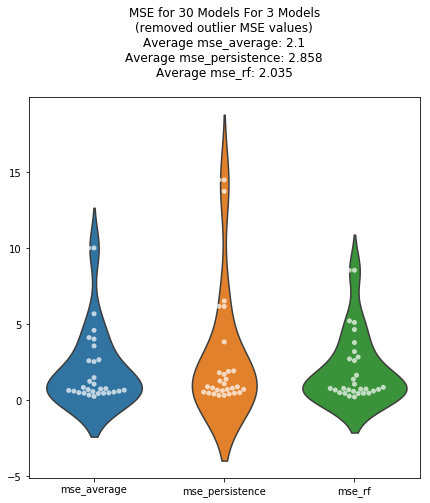

In [75]:
df = pd.read_csv("tables/3_mse.csv")
f, ax = plt.subplots(figsize=(7, 7))
df['mse_average'] = mstats.winsorize(df['mse_average'].values, limits=[0.00, 0.05])
df['mse_persistence'] = mstats.winsorize(df['mse_persistence'].values, limits=[0.00, 0.04])
df['mse_rf'] = mstats.winsorize(df['mse_rf'].values, limits=[0.00, 0.05])
sns.violinplot(data=df, ax=ax, inner=None)
sns.swarmplot(data=df, ax=ax, color='w', alpha=.7);
ax.set_title("""MSE for 30 Models For 3 Models
(removed outlier MSE values)
Average mse_average: {}
Average mse_persistence: {}
Average mse_rf: {}
""".format(np.round(df['mse_average'].mean(),3),
           np.round(df['mse_persistence'].mean(),3), 
           np.round(df['mse_rf'].mean(),3)))


These are the predictions and actuals on the test set.
![predictions](images/4_predictions.png)



These are MSE values when trying 32 regression models on this dataset.  Many of them share similar scores, so I chose random forest.
![models](images/models.png)

### Ideas for Improving the Model
- Verify that the data is stationary
- Try Auto ARIMA and simpler forecasting methods
- Try Kaggle ideas for feature engineering with ML models
- Grid Search
- Ensemble
- Deep Learning